Nathan Dang

02/04/2020

DSCI225 - Applied Machine Learning

Instructor: Prof. Basye

# Lab 3 - Several Approaches to a Tricky Regression Problem

The purpose of this notebook is to try to learn from the Logistic Regression function.

## Get the data

To begin with, let's import some important libraries

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

We build two training sets, one with just a bunch of points X chosen randomly between +/- 10 and their correct y values and one where the y values have added Gaussian noise like the examples earlier in the chapter. Use a variance of 0.15 for your noise by multiplying the result of np.random.randn() by 0.15. Thus, we'll have one X and two different labels (y's), we'll call the them clean labels and the noisy labels. 

In [2]:
X = 20 * np.random.rand(200, 1) - 10
y_clean = 1 / (1 + np.exp(-X))
y_noisy = 1 / (1 + np.exp(-X + 0.15 * np.random.randn(200, 1)))

In [3]:
print(X.shape)
print(y_clean.shape)
print(y_noisy.shape)

(200, 1)
(200, 1)
(200, 1)


We split the data into traning and test sets, with the ratio of 0.7:0.3

In [4]:
X_clean_train, X_clean_test, y_clean_train, y_clean_test = train_test_split(X, y_clean, random_state=42, train_size=0.7)
X_noisy_train, X_noisy_test, y_noisy_train, y_noisy_test = train_test_split(X, y_noisy, random_state=42, train_size=0.7)

It's always good to have some visualisation of the data

In [5]:
def plot_data(X_train, y_train, X_test, y_test, title_train, title_test):
    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    plt.plot(X_train, y_train, 'r.', markersize=10, alpha=0.5)
    plt.xlabel("x", fontsize=15)
    plt.ylabel("y", rotation=0, fontsize=15)
    plt.title(title_train)

    plt.subplot(122)    
    plt.plot(X_test, y_test, 'b.', markersize=10, alpha=0.5)
    plt.xlabel("x", fontsize=15)
    plt.ylabel("y", rotation=0, fontsize=15)
    plt.title(title_test)

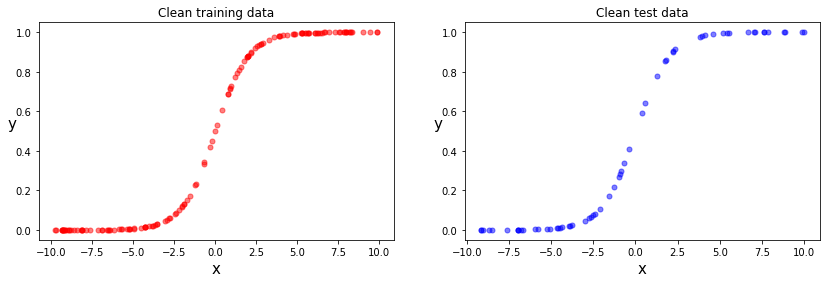

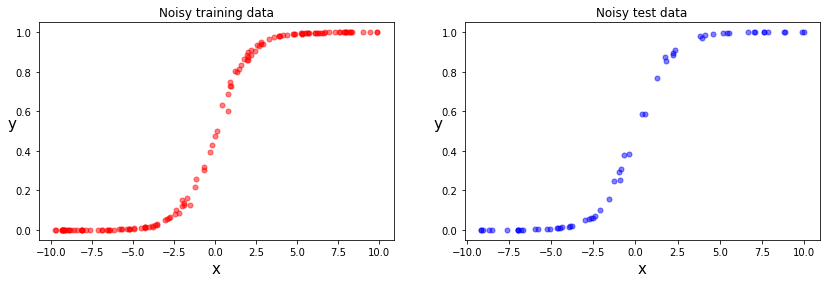

In [6]:
plot_data(X_clean_train, y_clean_train, X_clean_test, y_clean_test, "Clean training data", "Clean test data")
plot_data(X_noisy_train, y_noisy_train, X_noisy_test, y_noisy_test, "Noisy training data", "Noisy test data")

## Linear Regression

First, we begin by training two linear models (one each on the clean and noisy labels) and measuring their RMSE - these will be our baseline models. In all of what follows, we'll be building and training pairs of (clean, noisy) models and evaluating both.

In [7]:
from sklearn.metrics import mean_squared_error
def plot_train_eval(X_train, y_train, y_train_predict, X_test, y_test, y_test_predict, title_train, title_test):
    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    plt.plot(X_train, y_train_predict, "r.", linewidth=2, label="prediction")
    plt.plot(X_train, y_train, "b.", linewidth=2, label="y_clean_train")
    plt.xlabel("x", fontsize=15)
    plt.ylabel("y", rotation=0, fontsize=15)
    plt.legend(loc="upper left", fontsize=14)
    plt.title(title_train)

    plt.subplot(122)    
    plt.plot(X_test, y_test_predict, "r.", linewidth=2, label="prediction")
    plt.plot(X_test, y_test, "g.", linewidth=2, label="y_clean_test")
    plt.xlabel("x", fontsize=15)
    plt.ylabel("y", rotation=0, fontsize=15)
    plt.legend(loc="upper left", fontsize=14)
    plt.title(title_test)

In [8]:
from sklearn.linear_model import LinearRegression
def linear_reg(X_train, y_train, X_test, y_test):
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    y_train_predict = lin_reg.predict(X_train)
    y_test_predict = lin_reg.predict(X_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predict))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
    return y_train_predict, y_test_predict, rmse_train, rmse_test

Train the linear model for the clean set including visualisation and the RMSE score of the model

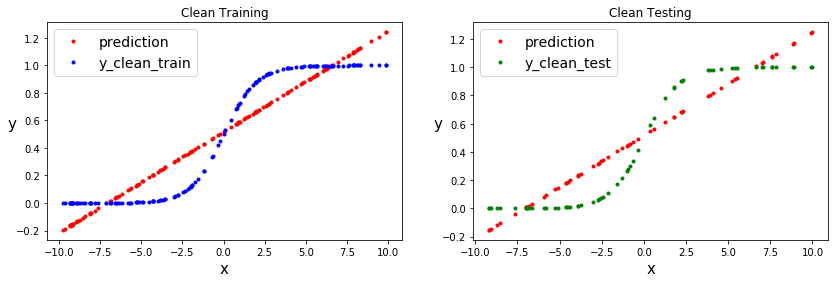

In [9]:
y_clean_train_predict, y_clean_test_predict, rmse_clean_train, rmse_clean_test = linear_reg(X_clean_train, y_clean_train, X_clean_test, y_clean_test)
plot_train_eval(X_clean_train, y_clean_train, y_clean_train_predict, X_clean_test, y_clean_test, y_clean_test_predict, "Clean Training", "Clean Testing")

In [10]:
print("RMSE (for training) =", rmse_clean_train)
print("RMSE (for testing) =", rmse_clean_test)

RMSE (for training) = 0.15818056175513073
RMSE (for testing) = 0.16401404772413591


Train the linear model for the noisy set including visualisation and the RMSE score of the model

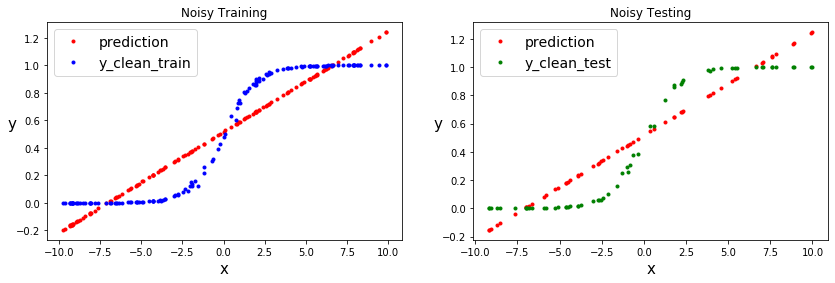

In [11]:
y_noisy_train_predict, y_noisy_test_predict, rmse_noisy_train, rmse_noisy_test = linear_reg(X_noisy_train, y_noisy_train, X_noisy_test, y_noisy_test)
plot_train_eval(X_noisy_train, y_noisy_train, y_noisy_train_predict, X_noisy_test, y_noisy_test, y_noisy_test_predict, "Noisy Training", "Noisy Testing")

In [12]:
print("RMSE (for training) =", rmse_noisy_train)
print("RMSE (for testing) =", rmse_noisy_test)

RMSE (for training) = 0.15888242924695575
RMSE (for testing) = 0.16344266558531054


<b>Observation: </b> the RMSE scores for both are not very much different from each other (with the scores of the noisy data are slightly bigger), we can also see from the two graphs above that the predictions are very similar. We will use these as our baselines.

## Polynomial Regression

Next, we will try building polynomial models of order 2, 3, 4, and 5 and see what kind of improvement you can get over the baselines we just obtained. We will first build models without regularisation and models with it later. 

This method builds polynomial models given a degree parameter without using regularisation

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
def poly_reg(X_train, y_train, X_test, y_test, degree_param):
    # Generate a new feature matrix consisting of all polynomial combinations of the features 
    # with degree less than or equal to the specified degree.
    poly_features = PolynomialFeatures(degree = degree_param, include_bias=False)
    polynomial_regression = Pipeline([
        ("poly_features", poly_features),
        ("lin_reg", LinearRegression()),
    ])
    polynomial_regression.fit(X_train, y_train)
    
    y_train_predict = polynomial_regression.predict(X_train)
    y_test_predict = polynomial_regression.predict(X_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predict))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
    
    # for visualisation
    X_model = np.linspace(-10, 10, 200).reshape(200, 1) 
    y_model_predict = polynomial_regression.predict(X_model)
    return X_model, y_model_predict, rmse_train, rmse_test

This method provides visualisation of the polynomial models on the training and test set

In [14]:
def draw_model(model_name, X_model, y_model_predict, X_train, y_train, X_test, y_test):
    # create the subplot with the training set
    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    plt.plot(X_train, y_train, 'r.', label='training data', markersize=10, alpha=0.5)
    plt.plot(X_model, y_model_predict, alpha=0.8, lw=2)
    plt.title(model_name + " (training)")
    plt.legend(loc='best')
    
    # create the subplot with the test data set
    plt.subplot(122)    
    plt.plot(X_test, y_test, 'b.', label='test data', markersize=10, alpha=0.5)
    plt.plot(X_model, y_model_predict, alpha=0.8, lw=2)
    plt.title(model_name + " (testing)")
    plt.legend(loc='best')

Train the polynomial models with different degree on the clean set and evaluate them using RMSE scores

RMSE (for training) -- Degree 2 = 0.15755536682210414
RMSE (for testing) -- Degree 2 = 0.1632587317075003
-----------------------------
RMSE (for training) -- Degree 3 = 0.07785173306156784
RMSE (for testing) -- Degree 3 = 0.08338414641498333
-----------------------------
RMSE (for training) -- Degree 4 = 0.07761325855225193
RMSE (for testing) -- Degree 4 = 0.08320870599690254
-----------------------------
RMSE (for training) -- Degree 5 = 0.0413937948197573
RMSE (for testing) -- Degree 5 = 0.043634595109000786
-----------------------------


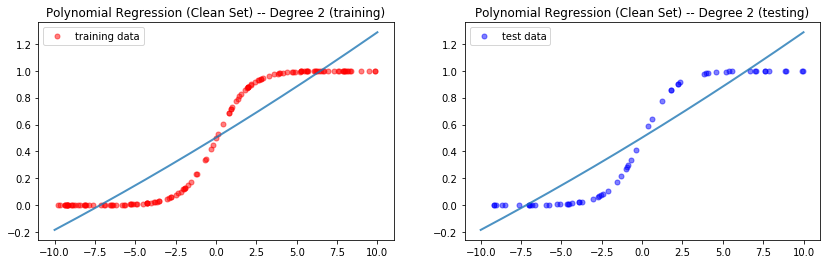

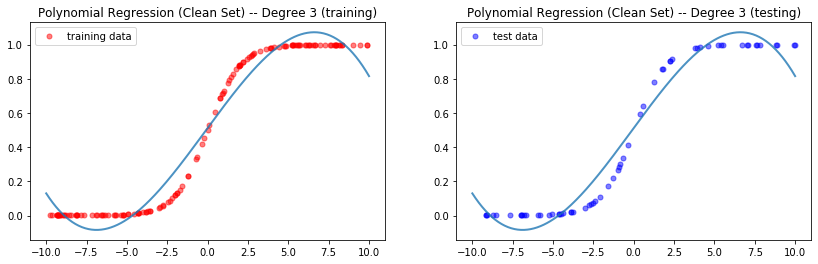

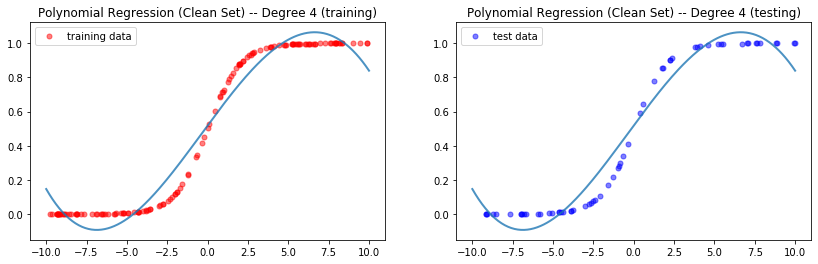

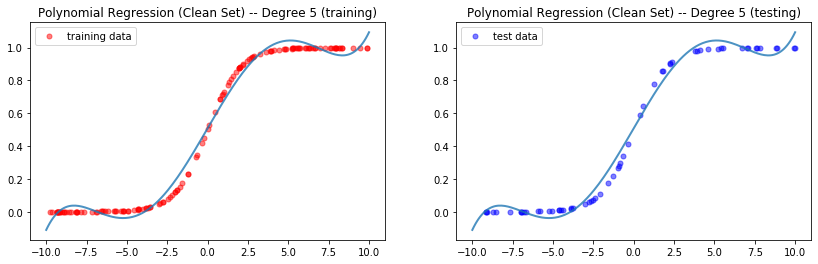

In [15]:
for i in range(2, 6):
    X_model, y_model_predict, rmse_train, rmse_test = poly_reg(X_clean_train, y_clean_train, X_clean_test, y_clean_test, i)
    draw_model("Polynomial Regression (Clean Set) -- Degree " + str(i), X_model, y_model_predict, X_clean_train, y_clean_train, X_clean_test, y_clean_test)
    print("RMSE (for training) -- Degree", str(i) + " =", rmse_train)
    print("RMSE (for testing) -- Degree", str(i) + " =", rmse_test)
    print("-----------------------------")

Train the polynomial models with different degree on the noisy set and evaluate them using RMSE scores

RMSE (for training) -- Degree 2 = 0.1581640745215322
RMSE (for testing) -- Degree 2 = 0.16252985639024284
-----------------------------
RMSE (for training) -- Degree 3 = 0.07924292634044634
RMSE (for testing) -- Degree 3 = 0.08276589114372006
-----------------------------
RMSE (for training) -- Degree 4 = 0.07908347643606901
RMSE (for testing) -- Degree 4 = 0.08265682924157985
-----------------------------
RMSE (for training) -- Degree 5 = 0.04383620859087777
RMSE (for testing) -- Degree 5 = 0.04335270291270177
-----------------------------


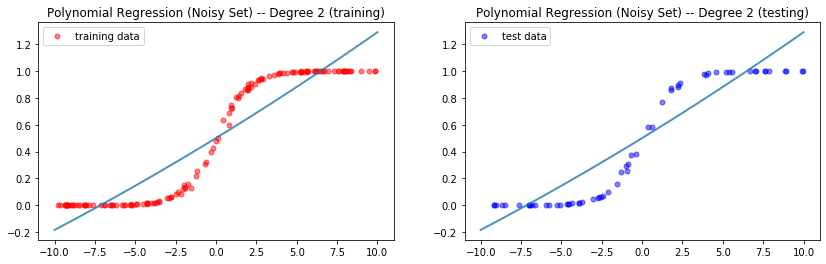

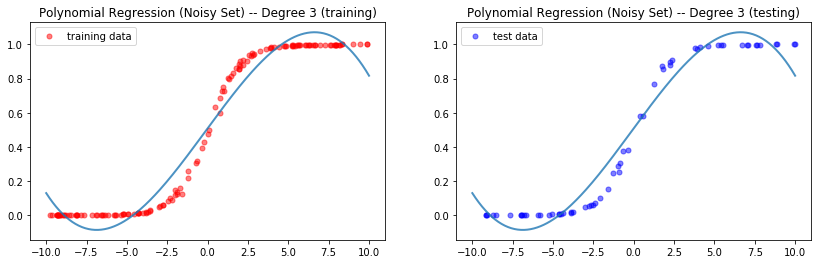

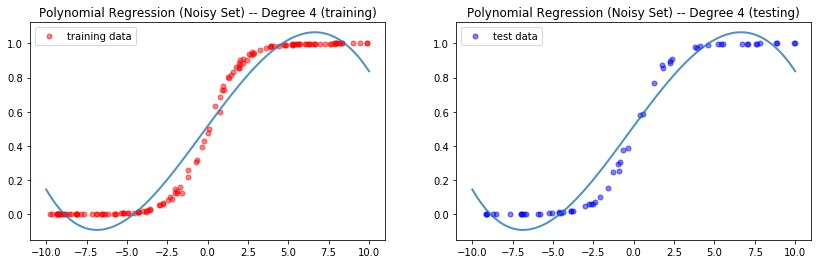

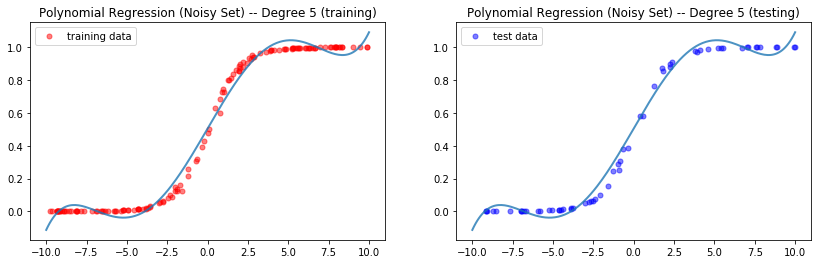

In [16]:
for i in range(2, 6):
    X_model, y_model_predict, rmse_train, rmse_test = poly_reg(X_noisy_train, y_noisy_train, X_noisy_test, y_noisy_test, i)
    draw_model("Polynomial Regression (Noisy Set) -- Degree " + str(i), X_model, y_model_predict, X_noisy_train, y_noisy_train, X_noisy_test, y_noisy_test)
    print("RMSE (for training) -- Degree", str(i) + " =", rmse_train)
    print("RMSE (for testing) -- Degree", str(i) + " =", rmse_test)
    print("-----------------------------")

<b>Observation: </b> we can see that as the order of the polynomial increases (starting from order 3), the model performs better (i.e. fit the training and test sets better resulting in lower RMSE scores compared to our baselines). Interestingly, the second order model gives us a straigt line.

Now, we will train our models using regularisation this time, let's do it with Elastic Net Regression

In [17]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
def poly_reg_regularised(X_train, y_train, X_test, y_test, degree_param):
    # Generate a new feature matrix consisting of all polynomial combinations of the features 
    # with degree less than or equal to the specified degree.
    poly_features = PolynomialFeatures(degree = degree_param, include_bias=False)
    polynomial_regression = Pipeline([
        ("poly_features", poly_features),
        ("elastic_reg", ElasticNet(alpha=0.01, l1_ratio=0.5)),
    ])
    polynomial_regression.fit(X_train, y_train)
    
    y_train_predict = polynomial_regression.predict(X_train)
    y_test_predict = polynomial_regression.predict(X_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predict))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
    
    # for visualisation
    X_model = np.linspace(-10, 10, 200).reshape(200, 1) 
    y_model_predict = polynomial_regression.predict(X_model)
    return X_model, y_model_predict, rmse_train, rmse_test

Train the regularised polynomial models with different degree on the clean set and evaluate them using RMSE scores

RMSE (for training) -- Degree 2 = 0.1575585019961595
RMSE (for testing) -- Degree 2 = 0.16328976342925194
-----------------------------
RMSE (for training) -- Degree 3 = 0.07789560173893534
RMSE (for testing) -- Degree 3 = 0.08328048270077702
-----------------------------
RMSE (for training) -- Degree 4 = 0.07765590309045382
RMSE (for testing) -- Degree 4 = 0.08312407816821438
-----------------------------
RMSE (for training) -- Degree 5 = 0.04164875289747347
RMSE (for testing) -- Degree 5 = 0.04380741422999419
-----------------------------


E:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006791322413219891, tolerance: 0.0028429660290656984
  positive)


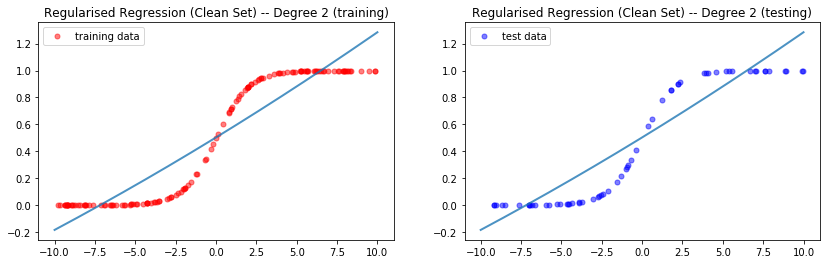

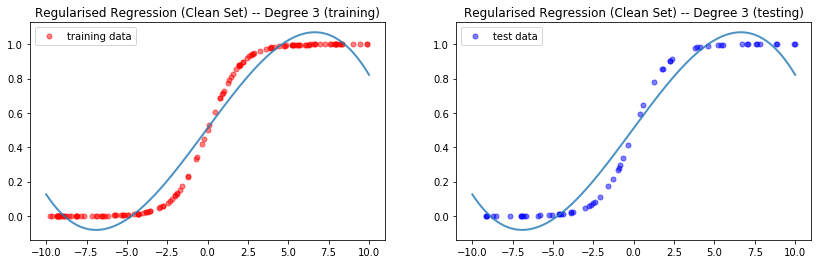

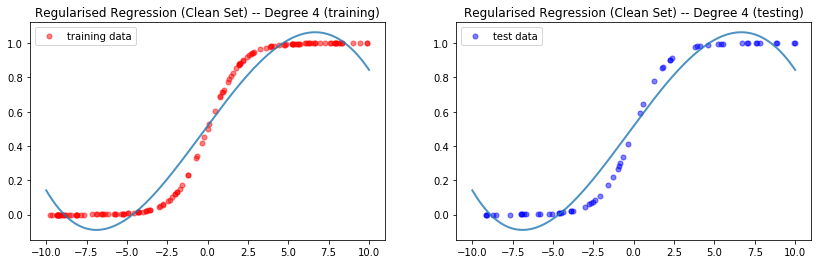

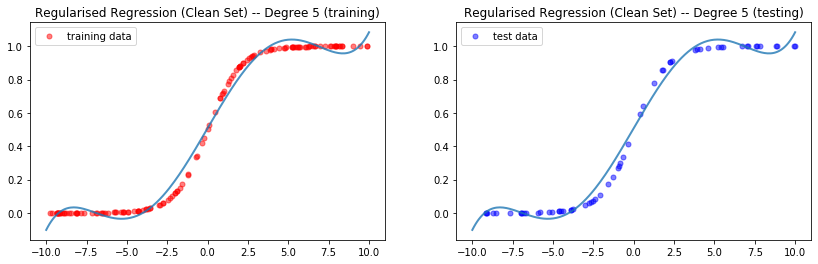

In [18]:
for i in range(2, 6):
    X_model, y_model_predict, rmse_train, rmse_test = poly_reg_regularised(X_clean_train, y_clean_train, X_clean_test, y_clean_test, i)
    draw_model("Regularised Regression (Clean Set) -- Degree " + str(i), X_model, y_model_predict, X_clean_train, y_clean_train, X_clean_test, y_clean_test)
    print("RMSE (for training) -- Degree", str(i) + " =", rmse_train)
    print("RMSE (for testing) -- Degree", str(i) + " =", rmse_test)
    print("-----------------------------")

Train the regularised polynomial models with different degree on the noisy set and evaluate them using RMSE scores

RMSE (for training) -- Degree 2 = 0.15816719778860364
RMSE (for testing) -- Degree 2 = 0.16255958148592783
-----------------------------
RMSE (for training) -- Degree 3 = 0.07928602309806275
RMSE (for testing) -- Degree 3 = 0.08264478591791077
-----------------------------
RMSE (for training) -- Degree 4 = 0.07912532415647097
RMSE (for testing) -- Degree 4 = 0.08255119582023397
-----------------------------
RMSE (for training) -- Degree 5 = 0.04407702069741476
RMSE (for testing) -- Degree 5 = 0.04343128401254351
-----------------------------


E:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0031043603719916324, tolerance: 0.0028448766139351966
  positive)


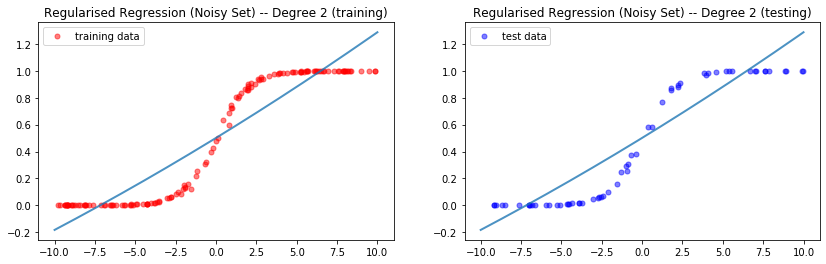

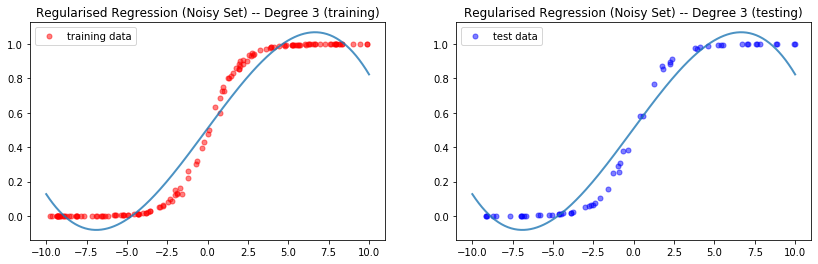

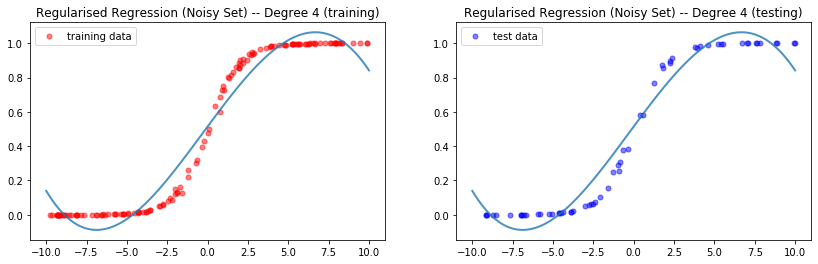

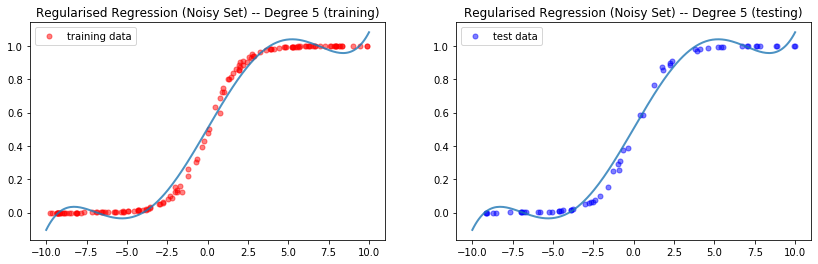

In [19]:
for i in range(2, 6):
    X_model, y_model_predict, rmse_train, rmse_test = poly_reg_regularised(X_noisy_train, y_noisy_train, X_noisy_test, y_noisy_test, i)
    draw_model("Regularised Regression (Noisy Set) -- Degree " + str(i), X_model, y_model_predict, X_noisy_train, y_noisy_train, X_noisy_test, y_noisy_test)
    print("RMSE (for training) -- Degree", str(i) + " =", rmse_train)
    print("RMSE (for testing) -- Degree", str(i) + " =", rmse_test)
    print("-----------------------------")

<b>Observation:</b> similarly to the previous case, the model performs better as the order increases. Furthermore, if we look at the scores more closely, we can see that the regularised models perform a little bit better than unregularised ones.   

Now, we will try building polynomial models of order 20 and use LASSO regularisation and see how many coefficients end up as 0.

In [20]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

def poly_reg_lasso(X_train, y_train, X_test, y_test):
    poly_features = PolynomialFeatures(degree = 20, include_bias=False)
    X_train_poly = poly_features.fit_transform(X_train)
    X_test_poly = poly_features.fit_transform(X_test)
    
    lasso_reg = Lasso()
    lasso_reg.fit(X_train_poly, y_train)

    y_train_predict = lasso_reg.predict(X_train_poly)
    y_test_predict = lasso_reg.predict(X_test_poly)

    # for visualisation
    X_model = np.linspace(-10, 10, 200).reshape(200, 1)
    X_model_poly = poly_features.fit_transform(X_model)
    y_model_predict = lasso_reg.predict(X_model_poly)

    # calculating the RMSE scores
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predict))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
    
    # listing coefficients
    coefs = lasso_reg.coef_
    
    return X_model, y_model_predict, rmse_train, rmse_test, coefs

E:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1852986122315263, tolerance: 0.0028429660290656984
  positive)


[ 0.00000000e+00 -0.00000000e+00  5.79732260e-03 -0.00000000e+00
 -9.76126897e-05 -4.20992156e-07  4.94283101e-08  2.81350862e-09
  3.18491855e-09  4.95325556e-11  2.24215454e-11  1.02453711e-15
  8.38777294e-14 -2.59515301e-15 -1.99413908e-16 -2.29363054e-17
 -8.73673330e-18 -4.78875278e-20 -1.30469617e-19  1.83852811e-21]


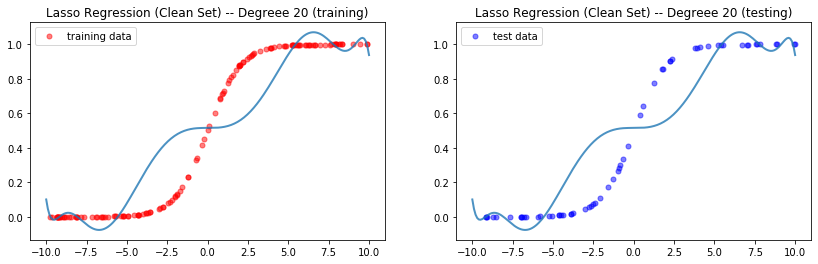

In [21]:
X_model, y_model_predict, rmse_train, rmse_test, coefs = poly_reg_lasso(X_clean_train, y_clean_train, X_clean_test, y_clean_test)
draw_model("Lasso Regression (Clean Set) -- Degreee 20", X_model, y_model_predict, X_clean_train, y_clean_train, X_clean_test, y_clean_test)
print(coefs)

E:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.202084878933829, tolerance: 0.0028448766139351966
  positive)


[ 0.00000000e+00 -0.00000000e+00  5.79467888e-03 -0.00000000e+00
 -9.75581192e-05 -3.84433554e-07  4.99737716e-08  2.36661586e-09
  3.17210789e-09  4.86371599e-11  2.24142872e-11  6.82788967e-15
  8.41212759e-14 -2.52204094e-15 -1.97596935e-16 -2.24438401e-17
 -8.72888078e-18 -4.58713939e-20 -1.30452528e-19  1.83337871e-21]


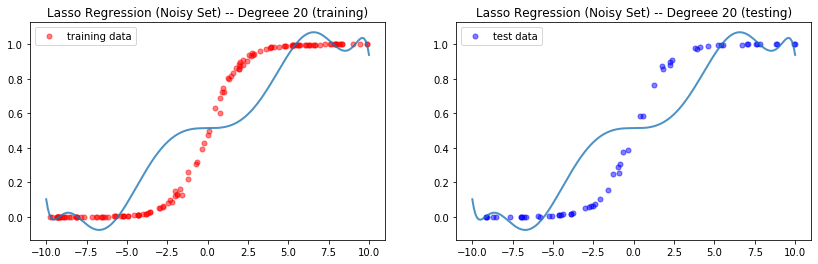

In [22]:
X_model, y_model_predict, rmse_train, rmse_test, coefs = poly_reg_lasso(X_noisy_train, y_noisy_train, X_noisy_test, y_noisy_test)
draw_model("Lasso Regression (Noisy Set) -- Degreee 20", X_model, y_model_predict, X_noisy_train, y_noisy_train, X_noisy_test, y_noisy_test)
print(coefs)

<b>Observation: </b> For both cases, there are 3 coefficients that end up as 0, and more than half of the rest are very close to 0. These numbers might slightly change when we run the whole notebook from the beginning as the data is random generated points.

## Other Regression Algorithms

Lastly, we will try building SVR models with polynomial kernels with degree 3 and decision tree regression and compare the results of those models with our baselines.

First, let's train out models using support vector regressor

In [23]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

def poly_reg_svr(X_train, y_train, X_test, y_test):
    sv_reg = SVR(kernel="poly", C=1, degree=3, gamma = 'auto')
    sv_reg.fit(X_train, y_train.ravel())

    y_train_predict = sv_reg.predict(X_train)
    y_test_predict = sv_reg.predict(X_test)

    # for visualisation
    X_model = np.linspace(-10, 10, 200).reshape(200, 1)
    y_model_predict = sv_reg.predict(X_model)

    # calculating the RMSE scores
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predict))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
    
    return X_model, y_model_predict, rmse_train, rmse_test

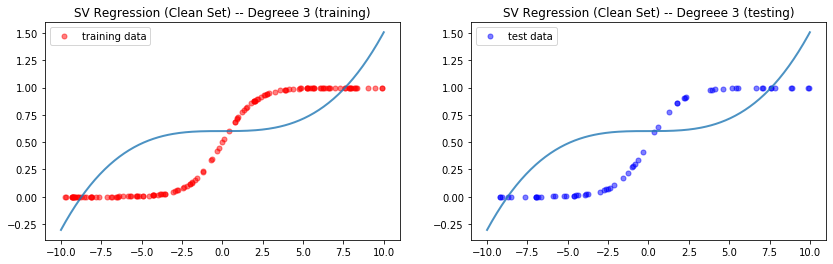

In [24]:
X_model, y_model_predict, rmse_train, rmse_test = poly_reg_svr(X_clean_train, y_clean_train, X_clean_test, y_clean_test)
draw_model("SV Regression (Clean Set) -- Degreee 3", X_model, y_model_predict, X_clean_train, y_clean_train, X_clean_test, y_clean_test)

In [25]:
print("RMSE (for training) =", rmse_train)
print("RMSE (for testing) =", rmse_test)

RMSE (for training) = 0.312203445889143
RMSE (for testing) = 0.3446841884255909


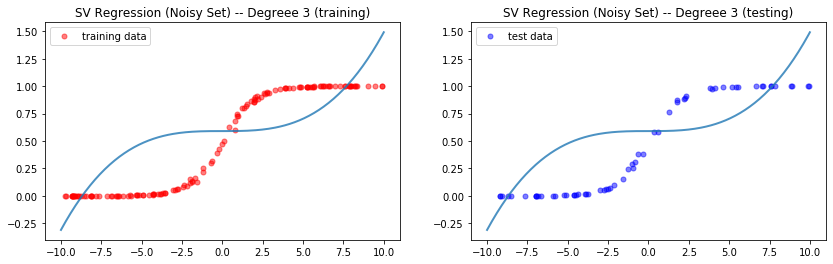

In [26]:
X_model, y_model_predict, rmse_train, rmse_test = poly_reg_svr(X_noisy_train, y_noisy_train, X_noisy_test, y_noisy_test)
draw_model("SV Regression (Noisy Set) -- Degreee 3", X_model, y_model_predict, X_noisy_train, y_noisy_train, X_noisy_test, y_noisy_test)

In [27]:
print("RMSE (for training) =", rmse_train)
print("RMSE (for testing) =", rmse_test)

RMSE (for training) = 0.3105469480596116
RMSE (for testing) = 0.3399184064110231


<b>Observation:</b> it looks like our model built from support vector machine for both cases does not fit the data very well, specifically, the RMSE scores are higher than those of the baselines.

Now, let's train our model using decision tree regressor

In [28]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

def poly_reg_tree(X_train, y_train, X_test, y_test, depth):
    tree_reg = DecisionTreeRegressor(random_state=42, max_depth=depth)
    tree_reg.fit(X_train, y_train.ravel())

    y_train_predict = tree_reg.predict(X_train)
    y_test_predict = tree_reg.predict(X_test)

    # for visualisation
    X_model = np.linspace(-10, 10, 200).reshape(200, 1)
    y_model_predict = tree_reg.predict(X_model)

    # calculating the RMSE scores
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predict))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
    
    return X_model, y_model_predict, rmse_train, rmse_test

RMSE (for training) -- Depth 2 = 0.05226300651868123
RMSE (for testing) -- Depth 2 = 0.04776641622547638
-----------------------------
RMSE (for training) -- Depth 3 = 0.022566793163630812
RMSE (for testing) -- Depth 3 = 0.02933316311692468
-----------------------------
RMSE (for training) -- Depth 4 = 0.008473214975171289
RMSE (for testing) -- Depth 4 = 0.01486326158877008
-----------------------------
RMSE (for training) -- Depth 5 = 0.0037829585391418964
RMSE (for testing) -- Depth 5 = 0.011569921347225618
-----------------------------


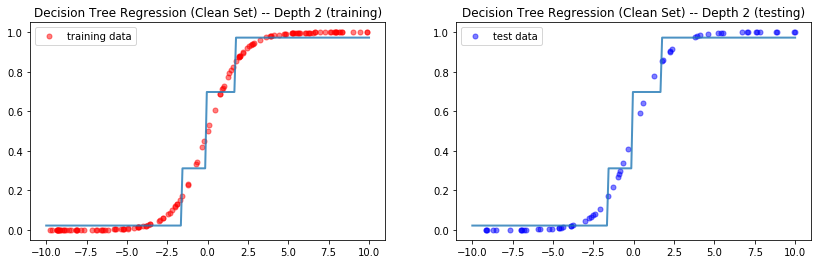

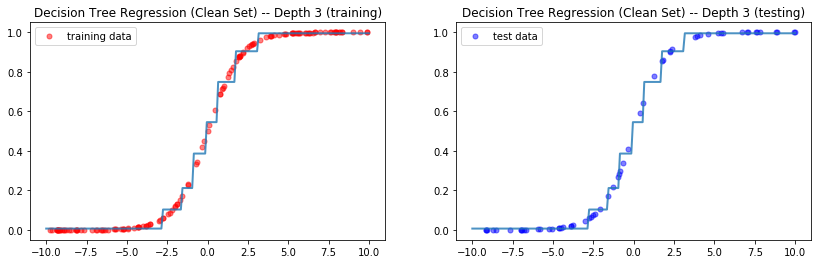

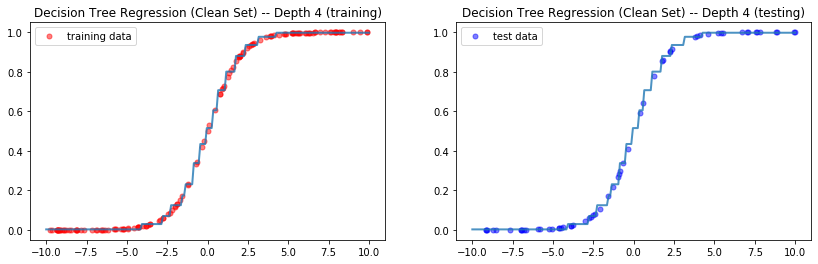

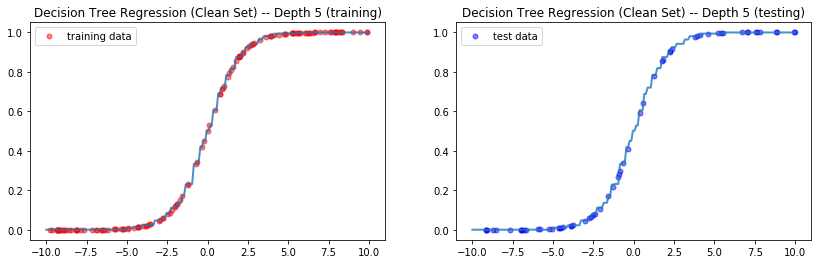

In [29]:
for i in range(2, 6):
    X_model, y_model_predict, rmse_train, rmse_test = poly_reg_tree(X_clean_train, y_clean_train, X_clean_test, y_clean_test, i)
    draw_model("Decision Tree Regression (Clean Set) -- Depth " + str(i), X_model, y_model_predict, X_clean_train, y_clean_train, X_clean_test, y_clean_test)
    print("RMSE (for training) -- Depth", str(i) + " =", rmse_train)
    print("RMSE (for testing) -- Depth", str(i) + " =", rmse_test)
    print("-----------------------------")

RMSE (for training) -- Depth 2 = 0.05248390889760485
RMSE (for testing) -- Depth 2 = 0.05003182631512377
-----------------------------
RMSE (for training) -- Depth 3 = 0.023085147631523254
RMSE (for testing) -- Depth 3 = 0.02432868416182479
-----------------------------
RMSE (for training) -- Depth 4 = 0.009711484465400776
RMSE (for testing) -- Depth 4 = 0.018673324972789743
-----------------------------
RMSE (for training) -- Depth 5 = 0.004717548534471905
RMSE (for testing) -- Depth 5 = 0.016531289124463583
-----------------------------


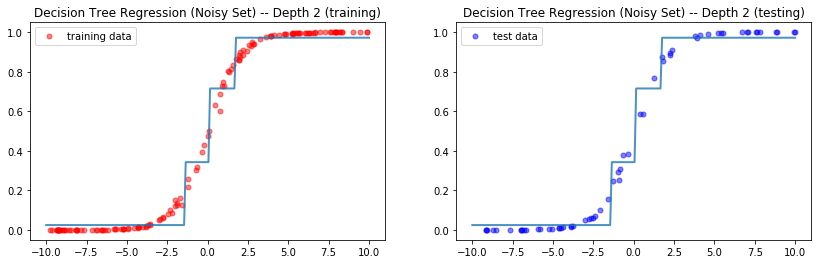

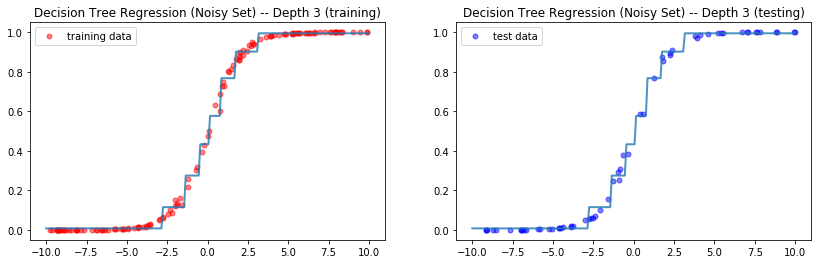

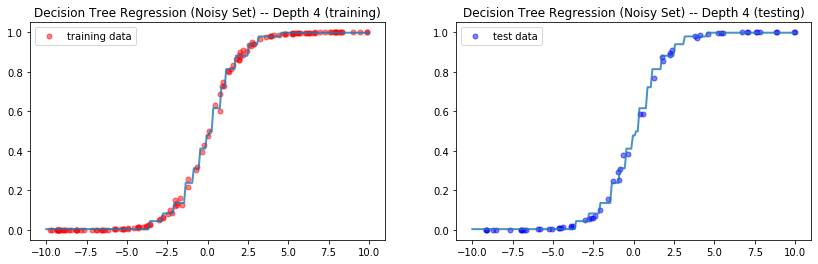

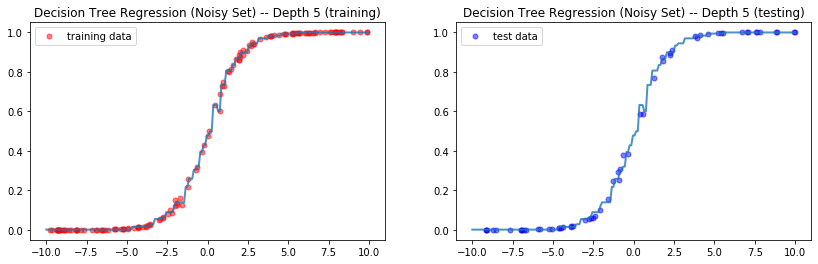

In [30]:
for i in range(2, 6):
    X_model, y_model_predict, rmse_train, rmse_test = poly_reg_tree(X_noisy_train, y_noisy_train, X_noisy_test, y_noisy_test, i)
    draw_model("Decision Tree Regression (Noisy Set) -- Depth " + str(i), X_model, y_model_predict, X_noisy_train, y_noisy_train, X_noisy_test, y_noisy_test)
    print("RMSE (for training) -- Depth", str(i) + " =", rmse_train)
    print("RMSE (for testing) -- Depth", str(i) + " =", rmse_test)
    print("-----------------------------")

<b>Observation: </b> it seems that the decision tree regressor does a very good job on fitting the data for both cases. Compared to the baselines and the other models we have built previously, the decision tree regressor has the best performance, that is, achieves the lowest RMSE scores.

This is the end of the notebook, and if I didn't do anything wrong, here are a few takeaways:

* Polynomial regression fits the data pretty well as the order of the model increases (starting from 3), but we can be sure that if we increase the order up to a certain level, it will cause overfit. Interestingly, the second order model gives us a straight line.

* The regularised poly models perform slightly better than normal ones.

* The support vector machine model's performance is worse than that of the baselines.

* The decision tree model has the best performance.

Note: The numbers (the scores, the coefs of LASSO) might slightly change when we run the whole notebook from the beginning as the data is random generated points.